# Импортирование необходимых библиотек

In [198]:
from sentinelhub import SHConfig
from sentinelhub import SentinelHubCatalog
from scipy.stats import skew, mode, kurtosis, norm

import datetime, os, csv, math
from datetime import timezone, timedelta
from math import ceil
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
from shapely.ops import unary_union
from fiona.drvsupport import supported_drivers
import geopandas as gpd
from matplotlib.path import Path
from shapely.geometry import Polygon
import earthpy.spatial as es
import earthpy.plot as ep
import numpy.ma as ma
from scipy.stats.mstats import gmean, hmean
import pandas as pd
import seaborn as sns
from functools import reduce
from itertools import tee, zip_longest

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from matplotlib.colors import ListedColormap

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    filter_times
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan',
          'gold', 'teal', 'lime', 'indigo', 'coral', 'darkred',
          'darkgreen', 'magenta', 'violet', 'turquoise', 'peachpuff',
          'slateblue', 'firebrick', 'forestgreen', 'plum', 'silver', 'lavender']

import csv, json, codecs, sys
import urllib.request
import urllib.error
import pandas as pd
import pickle, random

import requests
from bs4 import BeautifulSoup

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
sns.set()

config = SHConfig()

In [3]:
catalog = SentinelHubCatalog(config=config)
# catalog.get_info()

# Получение координат экспериментального пастбища 

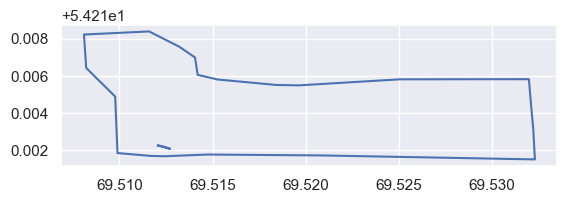

In [4]:
supported_drivers['KML'] = 'rw'
pasture_df = gpd.read_file('pasture.kml', driver='KML')

all_zagons = []
for zagon in range(len(pasture_df.index)):
    all_zagons.append(pasture_df.loc[zagon].geometry)
    
merged_zagons = unary_union(all_zagons)

gpd.GeoSeries([merged_zagons]).boundary.plot()
plt.show()

In [5]:
x_min, y_min, x_max, y_max = merged_zagons.bounds
pasture_coords_wgs84 = (x_min, y_min, x_max, y_max)

# Отправка запросов и получение снимков 

In [6]:
resolution = 10
pasture_bbox = BBox(bbox=pasture_coords_wgs84, crs=CRS.WGS84)
pasture_size = bbox_to_dimensions(pasture_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {pasture_size} pixels")

Image shape at 10 m resolution: (157, 78) pixels


# Выбор одной из доступных баз данных

In [7]:
data_collection = DataCollection.SENTINEL2_L2A
bands_dict = dict([(band.name, i) for i, band in enumerate(data_collection.bands)])
aux_data_dict = dict([(band, i) for i, band in enumerate(["sunZenithAngles","sunAzimuthAngles","viewZenithMean","viewAzimuthMean"])])

universal_bands_dict = dict([(band, i) for i, band in enumerate(["AOT", "SNW", "CLD", "SCL", "CLP", "CLM", "dataMask"])])

In [56]:
year = "2023"
time_interval = f"{year}-04-01", f"{year}-09-30"

In [57]:
# LOADINGS
with open(f'results_{year}.pkl', 'rb') as f:
    results = pickle.load(f)
    
with open(f'uni_bands_data_{year}.pkl', 'rb') as f:
    uni_bands_data = pickle.load(f)
    
with open(f'all_bands_data_{year}.pkl', 'rb') as f:
    all_bands_data = pickle.load(f)

with open(f'aux_data_{year}.pkl', 'rb') as f:
    aux_data = pickle.load(f)
    
with open(f'unique_acquisitions_{year}.pkl', 'rb') as f:
    unique_acquisitions = pickle.load(f)         

# Составление маски пастбища

In [58]:
 aoi_height, aoi_width, _ = all_bands_data[-1].shape

In [59]:
masks = []
pasture_edges = []
for zagon in range(len(pasture_df)-1):
    polygon=[]

    for coords in pasture_df.loc[zagon].geometry.exterior.coords:

        x = int(np.interp(coords[0], [x_min, x_max], [0, aoi_width]))
        y = int(np.interp(coords[1], [y_min, y_max], [aoi_height, 0]))

        polygon.append((y, x))
        
    poly_path=Path(polygon)
    x, y = np.mgrid[:aoi_height, :aoi_width]
    coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1)))
    
    pasture_edges.append(Polygon(polygon))
    
    mask = ~poly_path.contains_points(coors)
    masks.append(mask)
    
combined_mask = reduce(np.logical_and, masks)

# Маска для загона №1 

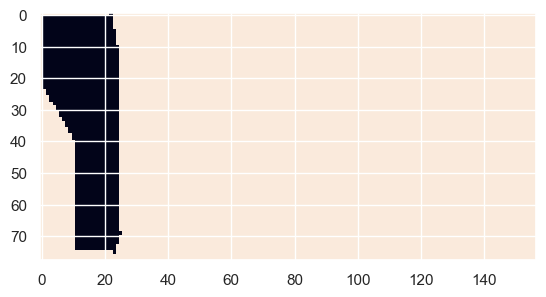

In [60]:
plt.imshow(masks[0].reshape(aoi_height, aoi_width))
plt.show()

# Маска для пастбища

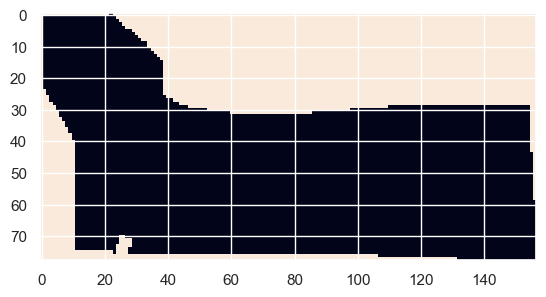

In [61]:
plt.imshow(combined_mask.reshape(aoi_height, aoi_width))
plt.show()

# Объявление вспомогательных функции

In [205]:
weights = {
    'temperature_2m_max': 1,
    'temperature_2m_min': 1,
    'apparent_temperature_max': 1,
    'apparent_temperature_min': 1,
    'precipitation_sum': 1,
    'rain_sum': 1,
    'snowfall_sum': 1,
    'precipitation_hours': 1,
    'windspeed_10m_max': 1,
    'winddirection_10m_dominant': 1,
    'shortwave_radiation_sum': 1,
    'et0_fao_evapotranspiration': 1,
    'sunZenithAngles': 0,
    'sunAzimuthAngles': 0,
    'viewZenithMean': 0,
    'viewAzimuthMean': 0,
}

def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band - band_min)/((band_max - band_min)))

def brighten(band):
    alpha=0.13
    beta=0
    return np.clip(alpha*band+beta, 0, 255)

def Kcluster(matrix, n_clusters=3):
#     scaler = MinMaxScaler(); matrix = scaler.fit_transform(matrix);
#     scaler = StandardScaler(); matrix = scaler.fit_transform(matrix);

    flattened_matrix = matrix.flatten()

    kmeans = KMeans(n_clusters=n_clusters, random_state=45)
    kmeans.fit(flattened_matrix.reshape(-1, 1))

    cluster_labels = kmeans.labels_
    result_index = cluster_labels.reshape(matrix.shape)
    result_index = ma.masked_array(result_index, mask=combined_mask.reshape(aoi_height, aoi_width))

    return ~(result_index == 0), ~(result_index == 1), ~(result_index == 2) 

def get_only_pasture(index):
    only_pasture = ma.masked_array(ma.masked_array((index), mask=np.isinf((index)) | np.isnan((index))), mask=combined_mask.reshape(aoi_height, aoi_width))
    return only_pasture

def get_only_zagon(index, zagon):
    only_zagon = ma.masked_array(ma.masked_array((index), mask=np.isinf((index)) | np.isnan((index))), mask=masks[zagon-1].reshape(aoi_height, aoi_width))
    return only_zagon

def change_difference(days_diff, zagon):
    if zagon > 0:
        return get_only_zagon(days_diff, zagon)
    else:
        return days_diff

def mean(index):
    return float(index.mean())

def median(index):
    return float(ma.median(index))

def get_date_slice(data, start_date, end_date):
    start_dt = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    end_dt = datetime.datetime.strptime(end_date, '%Y-%m-%d')
    result = {
        key: value
        for key, value in data.items()
        if start_dt <= datetime.datetime.strptime(key, '%Y-%m-%d') <= end_dt
    }
    return result

def pairwise(iterable):
    a, b = tee(iterable)
    next(b, None)
    return zip_longest(a, b)

def show_real_pasture():
    fig, ax = plt.subplots(figsize=(12, 6))
    for zagon in range(len(pasture_df)-1):
        ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])
    ep.plot_rgb(np.stack([RED, GREEN, BLUE]), ax=ax, title=general_info, figsize=(12, 6))
    plt.show()    

def show_hist_and_scatter(zagon, all_pasture_OR_each_paddock, paddock_id, header):
    i = paddock_id
    
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # Create side-by-side subplots

    # Histogram plot (left subplot)
    ax_hist = axs[0]
    n, bins, patches = ax_hist.hist(
        zagon.compressed(),  # Use .compressed() to handle masked arrays
        bins=30,
        color=colors[i],
        alpha=0.5,
        edgecolor='black',
        label="Гистограмма"
    )

    # Calculate statistics
    mean = zagon.mean()
    median = ma.median(zagon)
    std_dev = zagon.std()
    flattened_matrix = zagon.compressed()
    skewness_value = skew(flattened_matrix)
    Q1 = np.percentile(flattened_matrix, 25)
    Q3 = np.percentile(flattened_matrix, 75)
    IQR = Q3 - Q1
    kurtosis_value = kurtosis(flattened_matrix)

    # Add vertical lines
    ax_hist.axvline(zagon.max(), color='r', linestyle=':', linewidth=2, label=f"Макс.: {zagon.max()}")
    ax_hist.axvline(zagon.min(), color='b', linestyle=':', linewidth=2, label=f"Мин.: {zagon.min()}")
    ax_hist.axvline(mean, color='b', linestyle='dashed', linewidth=2, label=f"Средняя: {mean}")
    ax_hist.axvline(median, color='r', linestyle='dashed', linewidth=2, label=f"Медианная: {median}")

    # Mask negative or zero values for harmonic and geometric means
    if not (zagon <= 0).sum():
        harmonic_mean = hmean(flattened_matrix)
        geometric_mean = gmean(flattened_matrix)
        ax_hist.axvline(harmonic_mean, color='g', linestyle='dashed', linewidth=2, label=f"Гармоническая: {harmonic_mean}")
        ax_hist.axvline(geometric_mean, color='y', linestyle='dashed', linewidth=2, label=f"Геометрическая: {geometric_mean}")

    # Bell curve
    x = np.linspace(bins[0], bins[-1], 500)
    bell_curve = norm.pdf(x, loc=mean, scale=std_dev)
    bell_curve_scaled = bell_curve * n.max() / bell_curve.max()
    ax_hist.plot(x, bell_curve_scaled, color='m', linewidth=2, label="Нормальное распределение")

    # Annotate histogram with additional statistics
    ax_hist.axvline(mean, color='white', linestyle='--', label=f'Стандарт. отклонение: {std_dev}', alpha=0)
    ax_hist.axvline(mean, color='white', linestyle='--', label=f'Коэффициент асимметрии: {skewness_value}', alpha=0)
    ax_hist.axvline(mean, color='white', linestyle='--', label=f'Межквартильный размах: {IQR}', alpha=0)
    ax_hist.axvline(mean, color='white', linestyle='--', label=f'Величина эксцесса: {kurtosis_value}', alpha=0)

    # Finalize histogram
    ax_hist.legend(title=f'Сумма: {round(zagon.sum(), precision)}')
    
    if all_pasture_OR_each_paddock:
        ax_hist.set_title(f'{header} || Пастбище {general_info}')
    else:
        ax_hist.set_title(f'{header} || Загон-{i+1} {general_info}')
        
    ax_hist.set_xlabel('Значение')
    ax_hist.set_ylabel('Частота')

    # Scatter plot (right subplot)
    ax_scatter = axs[1]
    x = np.arange(zagon.size)
    y = zagon.flatten()
    unmasked_values = zagon.compressed()

    mean_value = np.ma.mean(zagon)
    median_value = np.ma.median(zagon)
    if not (zagon <= 0).sum():
        geometric_mean = gmean(unmasked_values)
        harmonic_mean = hmean(unmasked_values)

    ax_scatter.scatter(x, y, s=100, label="Значения", color=colors[i])
    ax_scatter.axhline(y=mean_value, color='b', linestyle='--', label=f'Средняя: {mean_value}')
    ax_scatter.axhline(y=median_value, color='r', linestyle='--', label=f'Медианная: {median_value}')
    if not (zagon <= 0).sum():
        ax_scatter.axhline(y=geometric_mean, color='y', linestyle='--', label=f'Геометрическая: {geometric_mean}')
        ax_scatter.axhline(y=harmonic_mean, color='g', linestyle='--', label=f'Гармоническая: {harmonic_mean}')

    if all_pasture_OR_each_paddock:
        ax_scatter.set_title(f'{header} || Пастбище {general_info}')
    else:
        ax_scatter.set_title(f'{header} || Загон-{i+1} {general_info}')
        
    ax_scatter.set_xlabel('Индекс')
    ax_scatter.set_ylabel('Значение')
    ax_scatter.legend()

    plt.tight_layout()
    plt.show()    


def show_pasture_index(test_meet, lower_bound, upper_bound, show_hists=True, save_excel=False, show_index=True, show_table=True):
    precision = 4
    header = None
    
    if show_index:
        fig, ax = plt.subplots(figsize=(12, 12))
        for zagon in range(len(pasture_df)-1):

            ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

        header = input_text
        # print(f"Макс: {round(float(test_meet.max()),precision)} || Мин: {round(float(test_meet.min()),precision)} || Сред: {round(float(test_meet.mean()),precision)} || Сумм: {round(float(test_meet.sum()),precision)}")
        ep.plot_bands(test_meet, title=f"{header} {general_info}", ax=ax, cmap="seismic", cols=1, vmin=lower_bound, vmax=upper_bound, figsize=(10, 14))
        plt.show()

    test_index_masked_array = []
    for i, mask in enumerate(masks):
        mx = ma.masked_array(test_meet, mask=mask.reshape(aoi_height, aoi_width))
        test_index_masked_array.append(mx)


    weather_parameters = history_df[history_df["time"]==date_chosen]

    weather_parameters = weather_parameters.assign(
        sunZenithAngles=SZA,
        sunAzimuthAngles=SAA,
        viewZenithMean=VZM,
        viewAzimuthMean=VAM)
    
#     weather_parameters = weather_parameters.drop(columns=["time"], inplace=False)
#     weighted_vector = (weather_parameters * pd.Series(weights)).sum(axis=1)
#     print(weighted_vector)
          
#     NWC = (float(weighted_vector.iloc[0]) - 393.2550463180542) / (590.1110732021332 - 393.2550463180542)
    
    summary_data = []
    for i, zagon in enumerate(test_index_masked_array):
#         resource = round(8.59 * ma.median(zagon) + 0.20 * NWC + -7.04, precision) 

        std_dev = zagon.std()
        flattened_matrix = zagon.compressed()
        skewness_value = skew(flattened_matrix)
        Q1 = np.percentile(flattened_matrix, 25); Q3 = np.percentile(flattened_matrix, 75)
        IQR = Q3 - Q1
        kurtosis_value = kurtosis(flattened_matrix)

        temp_resource = 8.87 * ma.median(zagon) + 0.03 * alter_weather_param_df["temp"].iloc[0] -7.91 # (Temperature)
        press_resource = 9.12 * ma.median(zagon) -0.01 * alter_weather_param_df["pressure"].iloc[0] + 2.18 # (Pressure)
        humid_resource = 8.49 * ma.median(zagon) -0.00 * alter_weather_param_df["humidity"].iloc[0] -6.66 # (Moisture)
        angle_resource = 8.95 * ma.median(zagon) -0.03 * (SZA + VZM) -6.06 # (SZA + VZM = RZA)

        resource = round(np.array([temp_resource, press_resource, humid_resource, angle_resource]).mean(), precision)
                
        summary_data.append([f"№{i+1}", round(zagon.sum(),precision), round(zagon.mean(),precision), round(ma.median(zagon),precision), round(std_dev,precision), round(skewness_value,precision), round(IQR,precision), round(kurtosis_value,precision), round(zagon.max(),precision), round(zagon.min(),precision), round(ma.count(zagon)*(10**2)*0.0001,precision), resource])


    styles = [
        {'selector': '',
         'props': [('border', '2px solid #000'), ('border-collapse', 'collapse')]},
        {'selector': 'th',
         'props': [('border', '2px solid #000')]},
        {'selector': 'td',
         'props': [('border', '1px solid #000'), ('padding', '5px')]}
    ]

    summary_df = pd.DataFrame(data = summary_data, columns=["Загон", "Сумма", "Cреднаяя", "Медианная", "Станд. откл.", "Коэф. асимм.", "Межкв. размах", "Велич. эксц.", "Макс", "Мин", "Площадь (га)", "Ресурс (т/га)"])

    std_dev = test_meet.std()
    flattened_matrix = test_meet.compressed()
    skewness_value = skew(flattened_matrix)
    Q1 = np.percentile(flattened_matrix, 25); Q3 = np.percentile(flattened_matrix, 75)
    IQR = Q3 - Q1
    kurtosis_value = kurtosis(flattened_matrix)

    sum_row = pd.DataFrame({'Загон': ["Пастбище"], 
                            'Сумма': [summary_df['Сумма'].sum()], 
                            'Cреднаяя': [round(float(test_meet.mean()),precision)], 
                            'Медианная': [round(float(ma.median(test_meet)),precision)], 
                            
                            'Станд. откл.': [round(float(std_dev),precision)],
                            'Коэф. асимм.': [round(float(skewness_value),precision)],
                            'Межкв. размах': [round(float(IQR),precision)],
                            'Велич. эксц.': [round(float(kurtosis_value),precision)],
                            
                            'Макс': [summary_df['Макс'].max()], 
                            'Мин': [summary_df['Мин'].min()], 
                            'Площадь (га)': [summary_df['Площадь (га)'].sum()], 
                            'Ресурс (т/га)': [summary_df['Ресурс (т/га)'].sum()]}, index=[len(summary_df.index)])

    summary_df = pd.concat([summary_df, sum_row])
    if save_excel:
        summary_df.to_excel(f"Summary_{date_chosen}_{data_collection.processing_level}.xlsx", index=None)
    styled_df = summary_df.style.set_table_styles(styles)
    styled_df.hide(axis="index")
    
    if show_table:
        display(styled_df)
    
    if show_hists: 
        show_hist_and_scatter(test_meet, True, random.randint(1, len(colors)), header)
        # Loop through each dataset in test_index_masked_array
        for i, zagon in enumerate(test_index_masked_array):
            show_hist_and_scatter(zagon, False, i, header)
        
        
def get_all_bands(by_pasture=False):
    global ULTRA_BLUE, BLUE, GREEN, RED, RED_EDGE1, RED_EDGE2, RED_EDGE3, NIR, N_NIR, WV, SWIR_C, SWIR2, SWIR3, SAA, SZA, VAM, VZM
    
    if by_pasture:
        # Нормализированные по пастбищу
        ULTRA_BLUE = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B01"]])))

        BLUE = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B02"]])))
        GREEN = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B03"]])))
        RED = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B04"]])))

        RED_EDGE1 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B05"]])))
        RED_EDGE2 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B06"]])))
        RED_EDGE3 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B07"]])))

        NIR = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B08"]])))
        N_NIR = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B8A"]])))
        WV = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B09"]])))
        if "B10" in bands_dict:
            SWIR_C = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B10"]])))
        SWIR2 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B11"]])))
        SWIR3 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B12"]])))
    else:
        # НЕ Нормализированные по пастбищу
        ULTRA_BLUE = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B01"]])))

        BLUE = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B02"]])))
        GREEN = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B03"]])))
        RED = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B04"]])))

        RED_EDGE1 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B05"]])))
        RED_EDGE2 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B06"]])))
        RED_EDGE3 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B07"]])))

        NIR = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B08"]])))
        N_NIR = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B8A"]])))
        WV = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B09"]])))
        if "B10" in bands_dict:
            SWIR_C = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B10"]])))
        SWIR2 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B11"]])))
        SWIR3 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B12"]])))

    SAA = (aux_data[image_date][:, :, aux_data_dict["sunAzimuthAngles"]]).mean()
    SZA = (aux_data[image_date][:, :, aux_data_dict["sunZenithAngles"]]).mean()
    VAM = (aux_data[image_date][:, :, aux_data_dict["viewAzimuthMean"]]).mean()
    VZM = (aux_data[image_date][:, :, aux_data_dict["viewZenithMean"]]).mean()

# Выбор порога облачности

In [63]:
# cloud_brightness_percent = 40 # %
# cloud_coverage_percent = 1 # %

# white_noise_threshold = int(np.interp(cloud_brightness_percent, [0, 100], [0, 255]))
# white_noise_count = int(np.interp(cloud_coverage_percent, [0, 100], [0, (aoi_height*aoi_width)]))

white_noise_threshold = 255 # 50
white_noise_count = 12246 # 300 / 12246

In [64]:
image_date_cloud = []
for date in unique_acquisitions:
    for index in range(len(results)):
        if datetime.datetime.strptime(results[index]['properties']['datetime'], "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc) == date:
            image_date_cloud.append((str(date.date()), results[index]['properties']["eo:cloud_cover"]))
image_date_cloud = dict(image_date_cloud)

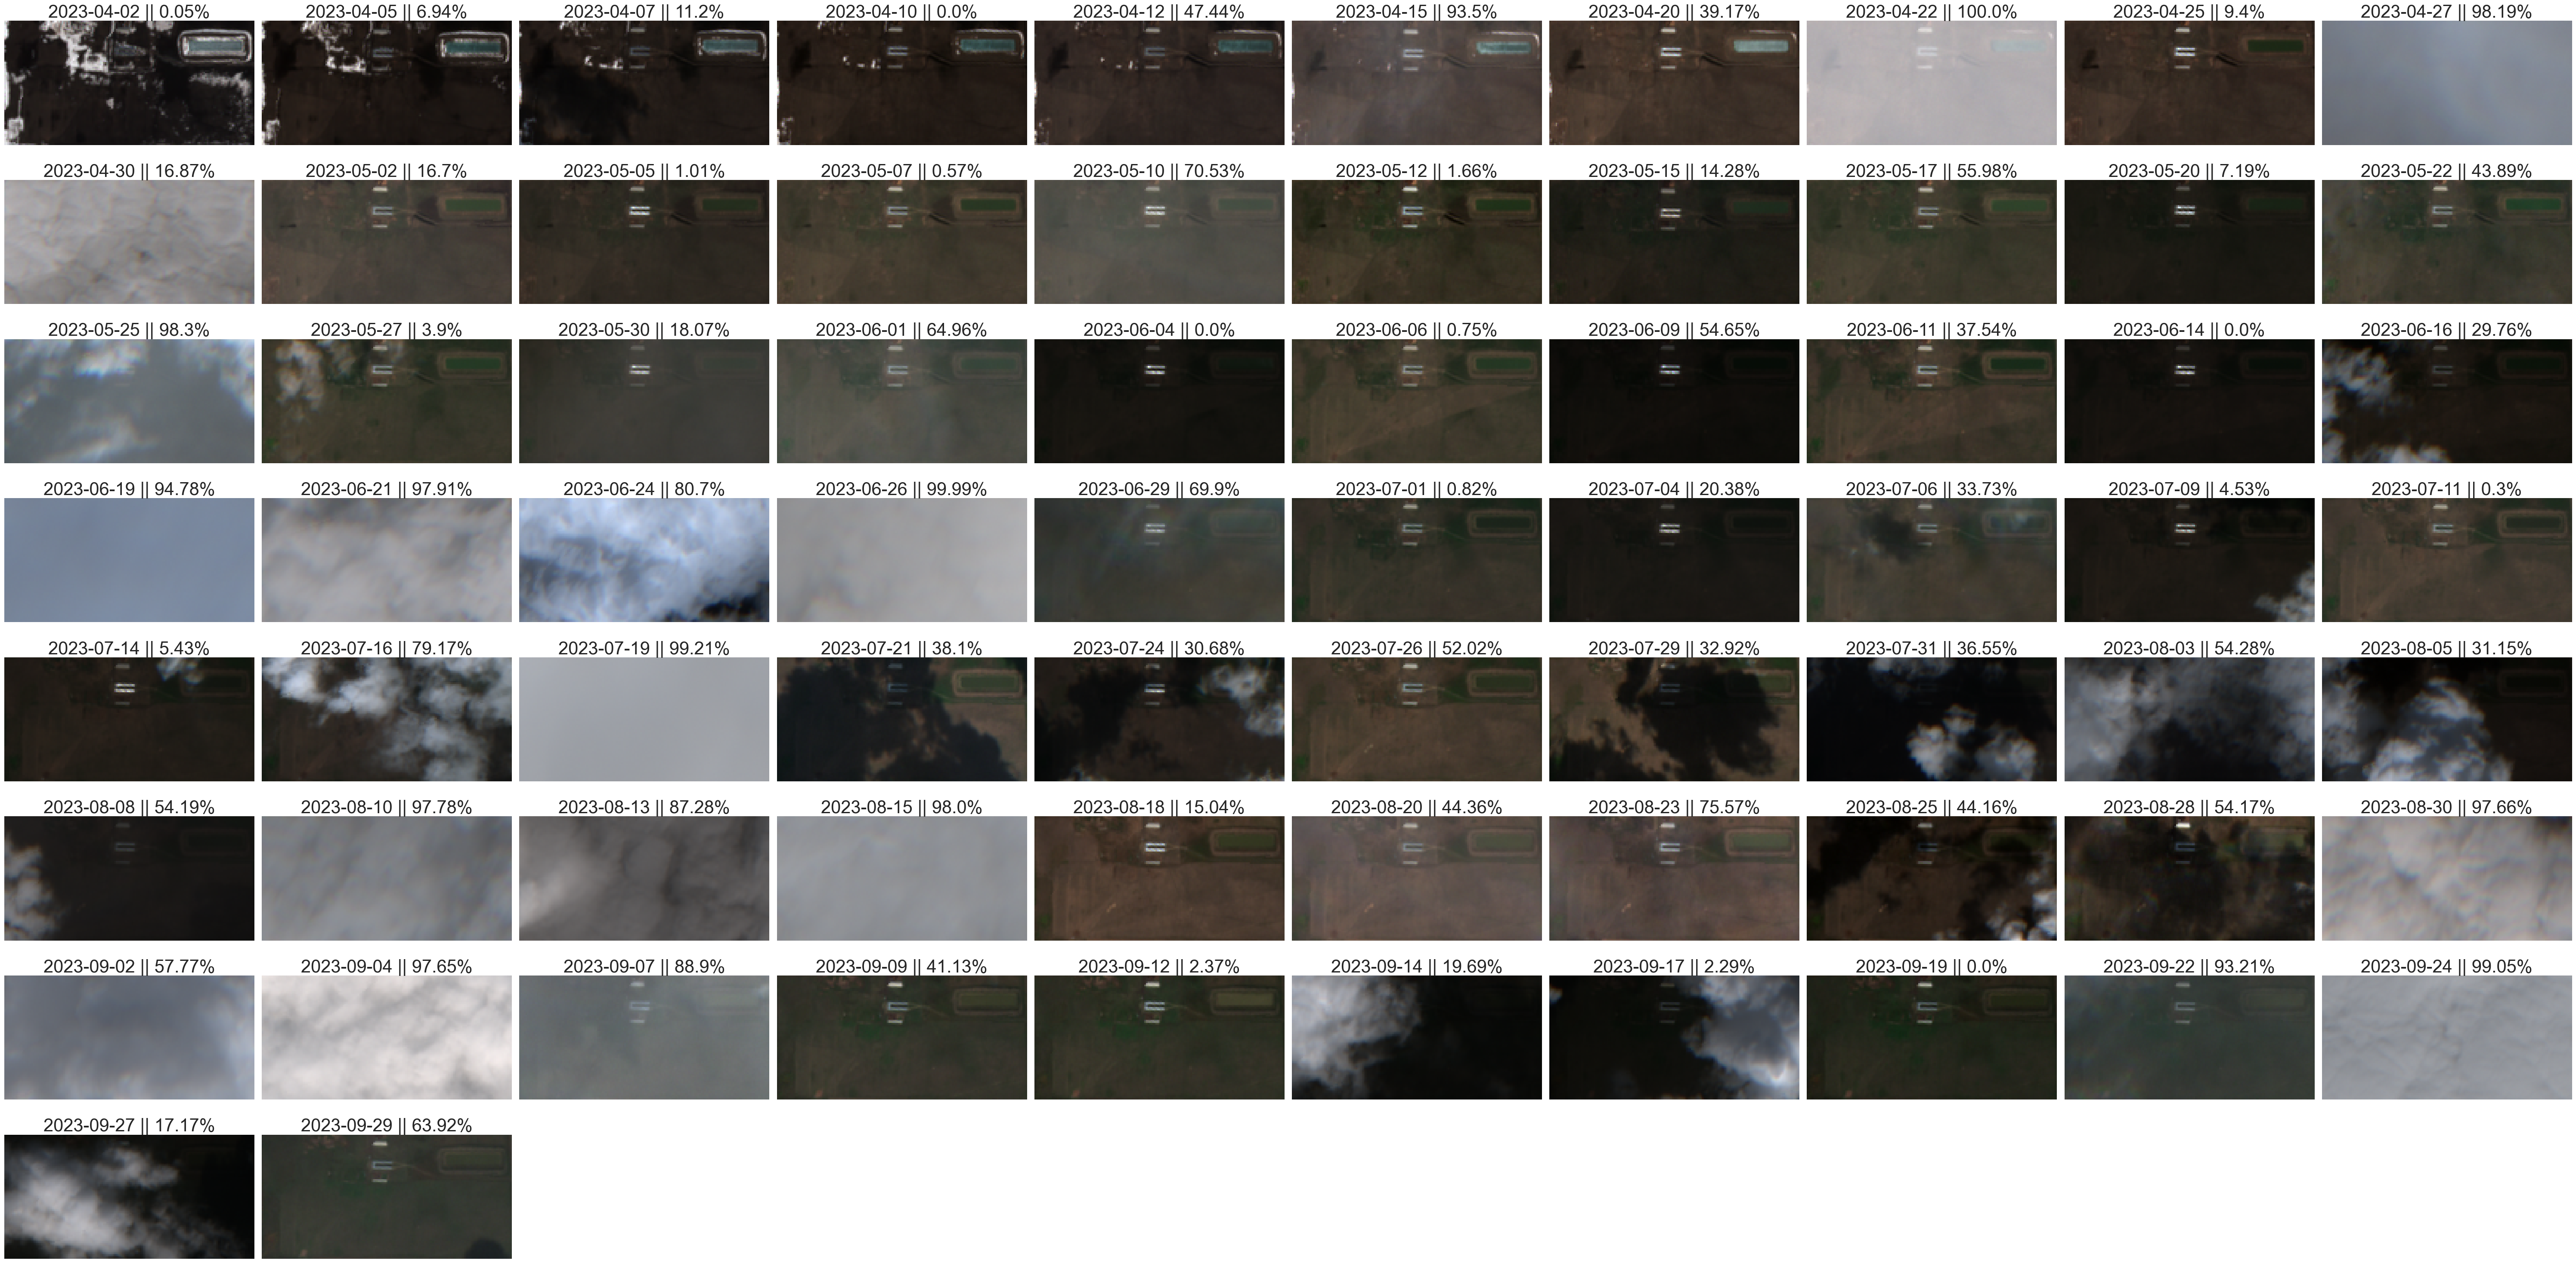

In [65]:
cols = 10
ncols, nrows = cols, ceil(len(results)/cols) 

fig, axis = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(60, 30), subplot_kw={"xticks": [], "yticks": [], "frame_on": False}
)

idx = 0
clear_date_dict = []
for i, (image, timestamp) in enumerate(zip(all_bands_data, unique_acquisitions)):

    data = image.astype(np.float64) / image.max()
    data = 255 * data
    image = data.astype(np.uint8)
    
    mx1 = ma.masked_array(image[:,:,bands_dict["B02"]], mask=combined_mask.reshape(aoi_height, aoi_width))
    mx2 = ma.masked_array(image[:,:,bands_dict["B03"]], mask=combined_mask.reshape(aoi_height, aoi_width))
    mx3 = ma.masked_array(image[:,:,bands_dict["B04"]], mask=combined_mask.reshape(aoi_height, aoi_width))
    comb = mx1&mx2&mx3
    white_image = comb >= white_noise_threshold
    if white_image.sum() <= white_noise_count:
        clear_date_dict.append((str(timestamp.date().isoformat()), i))
        ax = axis[idx // ncols][idx % ncols]
        image = np.stack([image[:,:,bands_dict["B04"]], image[:,:,bands_dict["B03"]], image[:,:,bands_dict["B02"]]])
        ax.imshow(np.transpose(image, (1, 2, 0)))
        ax.set_title(timestamp.date().isoformat()+ ' || ' + str(image_date_cloud[timestamp.date().isoformat()]) + "%", fontsize=30)
        idx += 1
        
clear_date_dict = dict(clear_date_dict)
plt.tight_layout()

# Анализ погодных параметров и каналов

## Координаты пастбища

In [66]:
longitude = pasture_bbox.geometry.centroid.coords.xy[0][0]
latitude = pasture_bbox.geometry.centroid.coords.xy[1][0]

In [67]:
forecast_parameters = [
"temperature_2m_max",
"temperature_2m_min",
"apparent_temperature_max",
"apparent_temperature_min",
"precipitation_sum",
"rain_sum",
"showers_sum",
"snowfall_sum",
"precipitation_hours",
"precipitation_probability_max",
"precipitation_probability_min",
"precipitation_probability_mean",
"weathercode",
"sunrise",
"sunset",
"windspeed_10m_max",
"windgusts_10m_max",
"winddirection_10m_dominant",
"shortwave_radiation_sum",
"et0_fao_evapotranspiration",
"uv_index_max",
"uv_index_clear_sky_max",]

history_parameters = [
"temperature_2m_max",
"temperature_2m_min",
"apparent_temperature_max",
"apparent_temperature_min",
"precipitation_sum",
"rain_sum",
"snowfall_sum",
"precipitation_hours",
"weathercode",
"sunrise",
"sunset",
"windspeed_10m_max",
"windgusts_10m_max",
"winddirection_10m_dominant",
"shortwave_radiation_sum",
"et0_fao_evapotranspiration",]


last_main_description = ""

def get_weather_mapping():
    global last_main_description
    
    url = "https://www.nodc.noaa.gov/archive/arc0021/0002199/1.1/data/0-data/HTML/WMO-CODE/WMO4677.HTM"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    weather_mapping = {}
    
    for i_table, table in enumerate(soup.select('table[BORDER]')):
        for i_row, row in enumerate(table.find_all('tr')[1:]):
            code_and_description = row.find_all('td')[:2]
            code = int(code_and_description[0].text.strip())
            description = code_and_description[1].text.strip()
            if not description.startswith("-"):
                last_main_description = description
            else:
                description = last_main_description
            weather_mapping[code] = description
            
            
    return weather_mapping

def weather_code_to_string(wmo_code):
    return weather_mapping.get(wmo_code, "Unknown Weather Code")

# Generate the weather mapping
weather_mapping = get_weather_mapping()


def apply_params_to_URL(URL, parameters):
    URL += "&daily="
    for i, parameter in enumerate(parameters):
        if i < len(parameters) - 1:
            URL += parameter + ","
        else:
            URL += parameter
    URL += "&timezone=auto"
    
    print("URL updated: ", URL)
    return URL

def make_API_request(URL):
    try:
        # Convert from bytes to text
        resp_text = urllib.request.urlopen(URL).read().decode('UTF-8')
        # Use loads to decode from text
        json_obj = json.loads(resp_text)
        print("Successfull API request!")
        return json_obj
    except urllib.error.HTTPError  as e:
        ErrorInfo= e.read().decode()
        print('Error code: ', e.code, ErrorInfo)
        sys.exit()
    except  urllib.error.URLError as e:
        ErrorInfo= e.read().decode()
        print('Error code: ', e.code,ErrorInfo)
        sys.exit()

# История погоды по заданному диапазону

In [68]:
start_date = time_interval[0]
end_date = time_interval[-1]

In [69]:
Hist_URL = f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}"

In [70]:
Hist_URL = apply_params_to_URL(Hist_URL, history_parameters)

URL updated:  https://archive-api.open-meteo.com/v1/archive?latitude=54.21495200000001&longitude=69.52020049999999&start_date=2023-04-01&end_date=2023-09-30&daily=temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,weathercode,sunrise,sunset,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration&timezone=auto


In [71]:
history_json_obj = make_API_request(Hist_URL)

Successfull API request!


In [72]:
history_df = pd.DataFrame(history_json_obj["daily"])
history_df.drop(columns=["weathercode", "sunrise", "sunset"], inplace=True)

In [73]:
history_df

time  temperature_2m_max  temperature_2m_min  \
0    2023-04-01                 9.4                -4.7   
1    2023-04-02                12.2                -3.7   
2    2023-04-03                16.3                -3.2   
3    2023-04-04                16.2                -1.8   
4    2023-04-05                18.5                -1.7   
..          ...                 ...                 ...   
178  2023-09-26                22.3                12.3   
179  2023-09-27                16.2                 9.1   
180  2023-09-28                15.5                 8.5   
181  2023-09-29                15.3                 7.5   
182  2023-09-30                15.3                 7.4   

     apparent_temperature_max  apparent_temperature_min  precipitation_sum  \
0                         3.2                     -10.3                0.0   
1                         7.1                      -8.7                0.0   
2                        12.4                      -7.6                0.0   
3                        12.4                      -6.1                0.0   
4                        14.4                      -5.5                0.0   
..                        ...                       ...                ...   
178                      20.4                      11.0                0.2   
179                      13.1                       7.1                0.1   
180                      12.6                       6.6                0.2   
181                      13.2                       5.3                0.0   
182                      14.5                       5.5                0.8   

     rain_sum  snowfall_sum  precipitation_hours  windspeed_10m_max  \
0         0.0           0.0                  0.0               21.6   
1         0.0           0.0                  0.0               16.3   
2         0.0           0.0                  0.0               12.0   
3         0.0           0.0                  0.0               12.9   
4         0.0           0.0                  0.0               13.0   
..        ...           ...                  ...                ...   
178       0.2           0.0                  1.0               19.3   
179       0.1           0.0                  1.0               13.4   
180       0.2           0.0                  2.0               16.4   
181       0.0           0.0                  0.0               10.7   
182       0.8           0.0                  4.0                8.6   

     windgusts_10m_max  winddirection_10m_dominant  shortwave_radiation_sum  \
0                 41.8                         138                    18.09   
1                 29.5                         148                    18.37   
2                 20.2                         161                    18.38   
3                 21.6                         136                    18.40   
4                 26.6                         153                    18.85   
..                 ...                         ...                      ...   
178               37.8                         280                    13.58   
179               28.8                         334                    13.03   
180               32.8                         273                     9.62   
181               23.0                         265                     9.86   
182               14.0                         224                     9.89   

     et0_fao_evapotranspiration  
0                          2.56  
1                          2.74  
2                          2.80  
3                          2.88  
4                          3.18  
..                          ...  
178                        2.74  
179                        2.12  
180                        1.64  
181                        1.52  
182                        1.47  

[183 rows x 14 columns]

In [74]:
def get_main_weather_params_history(seek_date):
    if isinstance(seek_date, list):
        l = []
        for d in seek_date:
            l.append(round_up_to_hour(d))
        date_list_df = pd.DataFrame({'dt_iso': l})
        df = pd.merge(grand_history_weather_df, date_list_df, on='dt_iso', how='right')
        df = df.drop(columns=['dt', 'dt_iso', 'timezone', 'city_name', 'lat', 'lon', 'weather_id', 'weather_main', 'weather_description', 'weather_icon'])
    else:
        df = grand_history_weather_df[grand_history_weather_df["dt_iso"] == round_up_to_hour(seek_date)]
        df = df.drop(columns=['dt', 'dt_iso', 'timezone', 'city_name', 'lat', 'lon', 'weather_id', 'weather_main', 'weather_description', 'weather_icon'])
    return df.reset_index(drop=True)

def round_up_to_hour(timestamp):
    if timestamp.minute >= 30:
        # If minutes are above 30, round up to the next hour
        rounded_timestamp = timestamp.replace(
            minute=0, second=0, microsecond=0
        ) + timedelta(hours=1)
    else:
        # Otherwise, round down to the current hour
        rounded_timestamp = timestamp.replace(minute=0, second=0, microsecond=0)

    return rounded_timestamp.strftime('%Y-%m-%d %H:%M:%S %z %Z')

grand_history_weather_df = pd.read_csv('Pasture_Weather_History.csv')

In [75]:
image_date_cloud = []
for date in unique_acquisitions:
    for index in range(len(results)):
        if datetime.datetime.strptime(results[index]['properties']['datetime'], "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc) == date:
            image_date_cloud.append((str(date.date()), results[index]['properties']["eo:cloud_cover"]))
image_date_cloud = dict(image_date_cloud)

# Дифференциальный анализ по дням

In [28]:
# results, uni_bands_data, all_bands_data, aux_data, unique_acquisitions

In [33]:
all_bands_data[0][:,:,0].shape

(78, 157)

In [76]:
desired_median = 0.91206

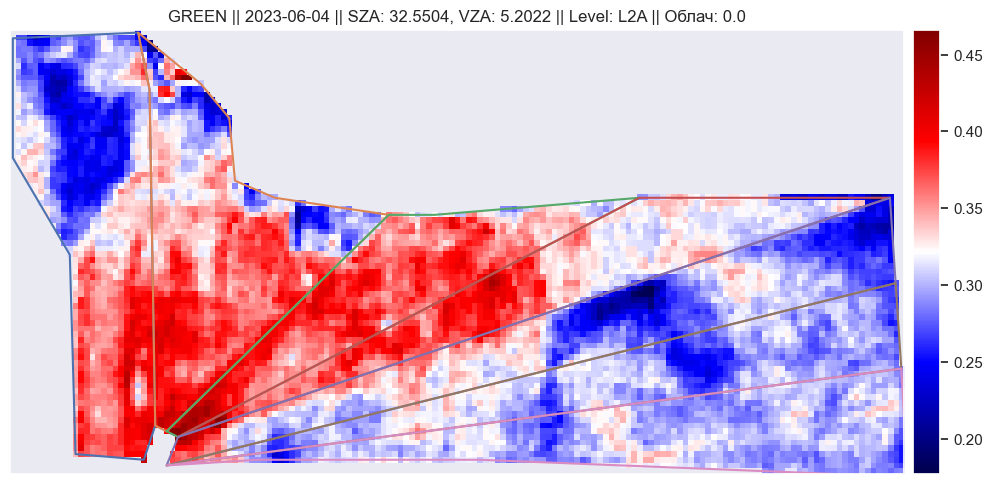

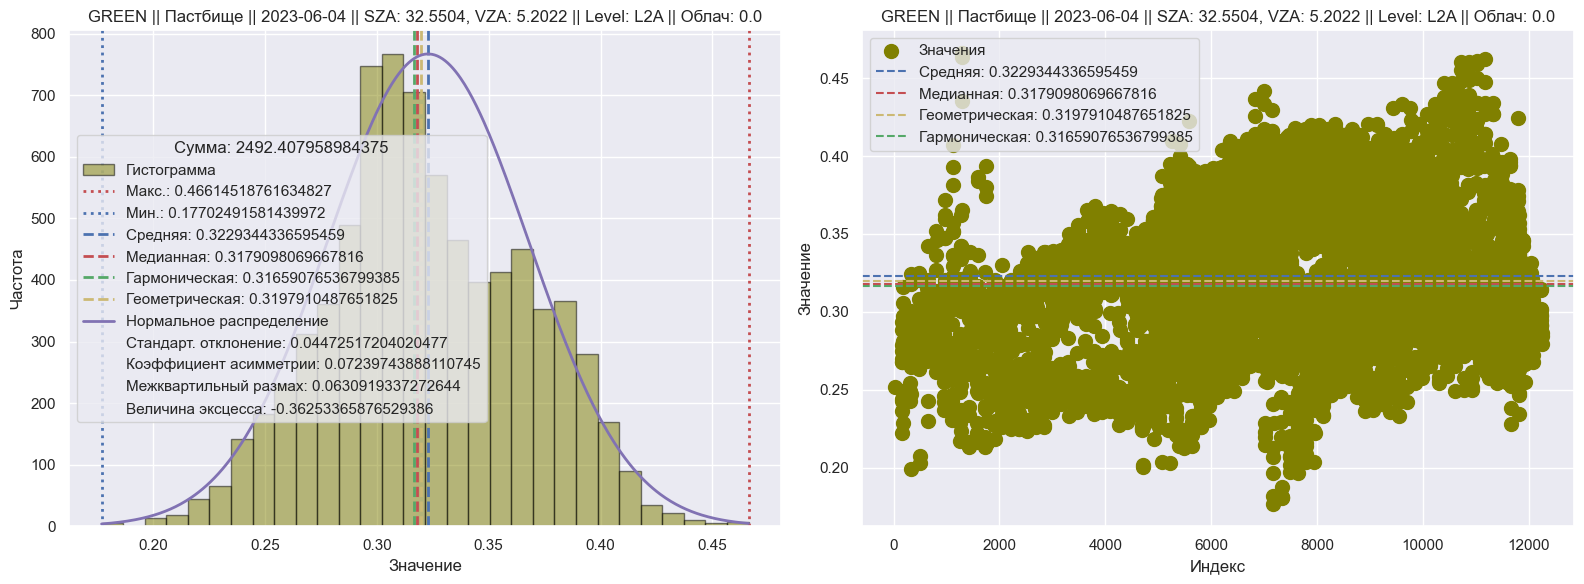

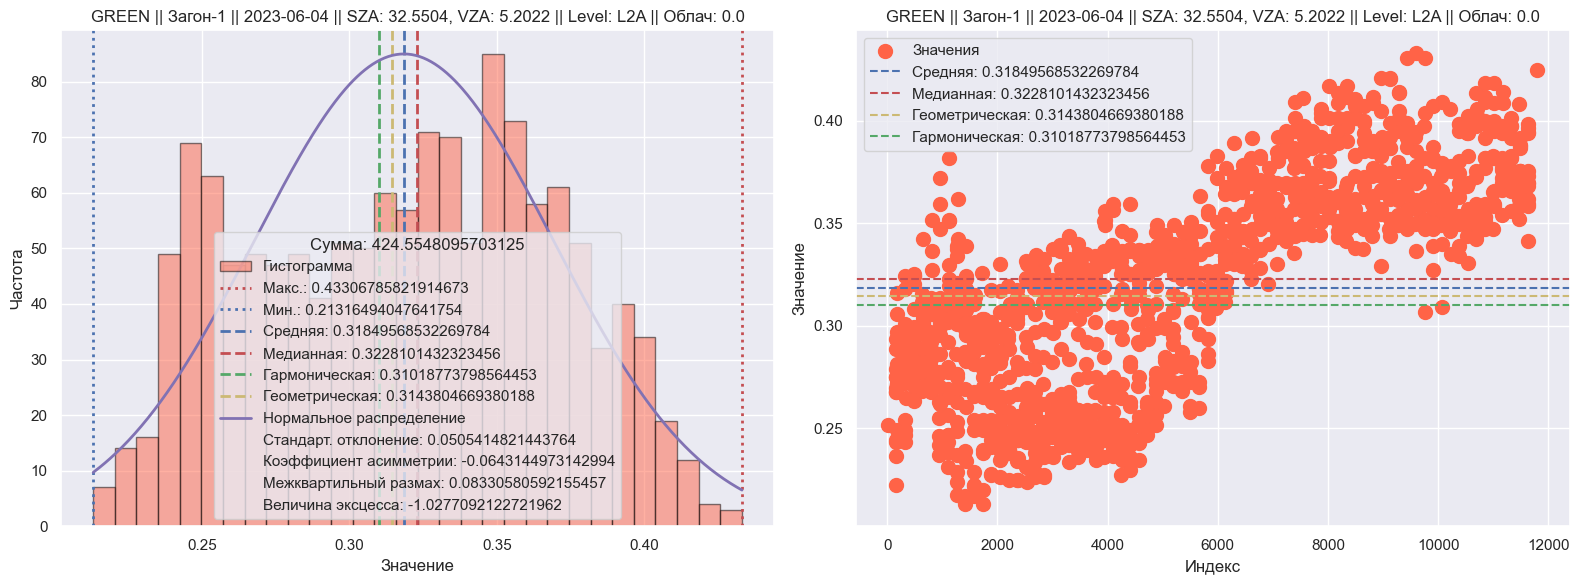

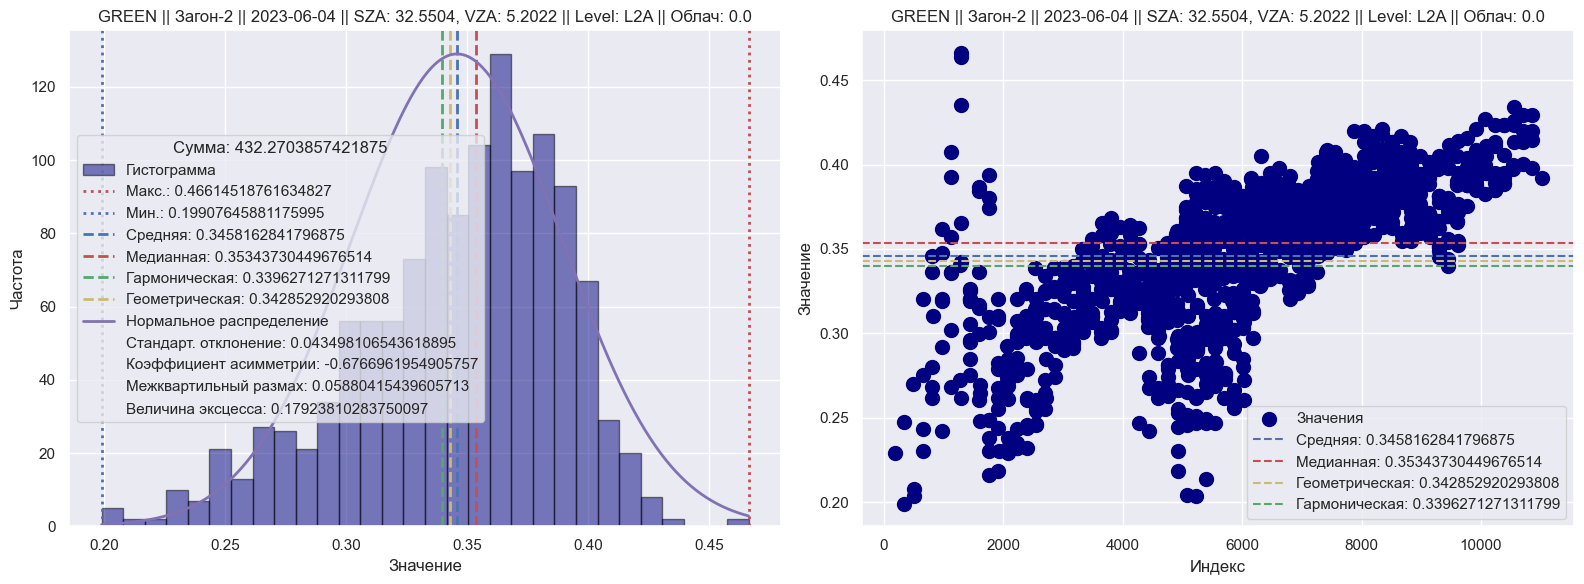

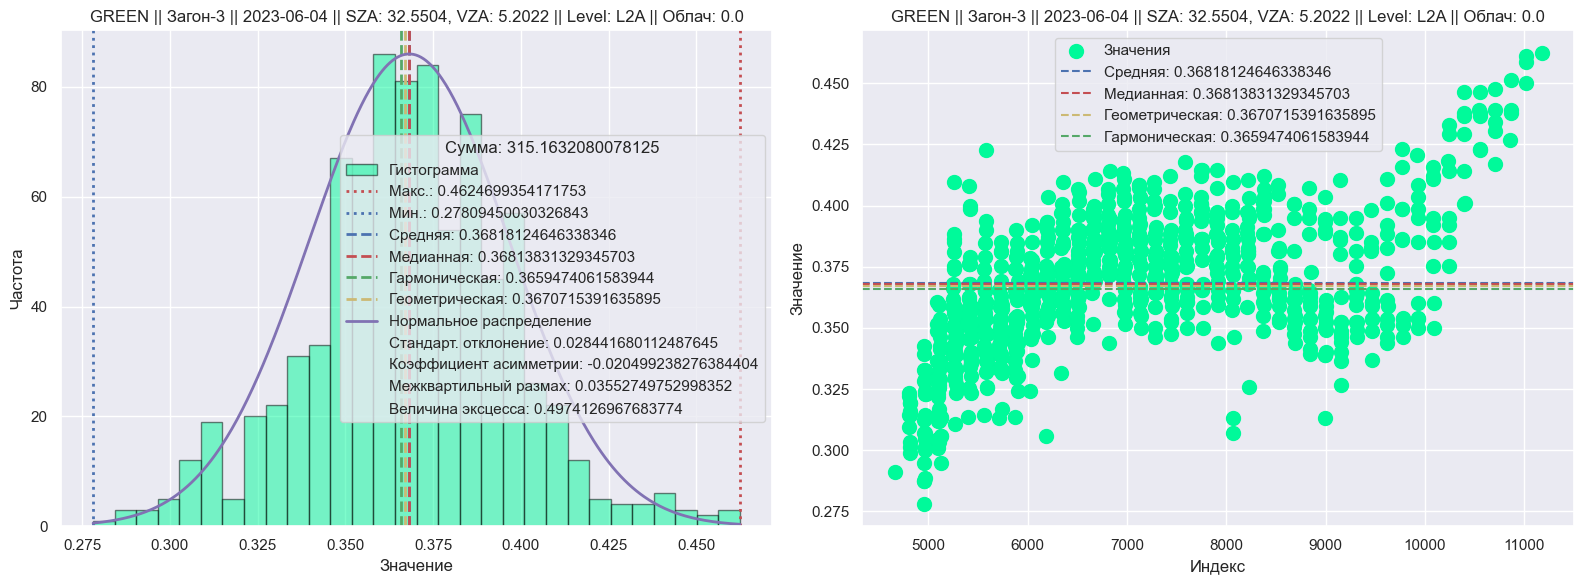

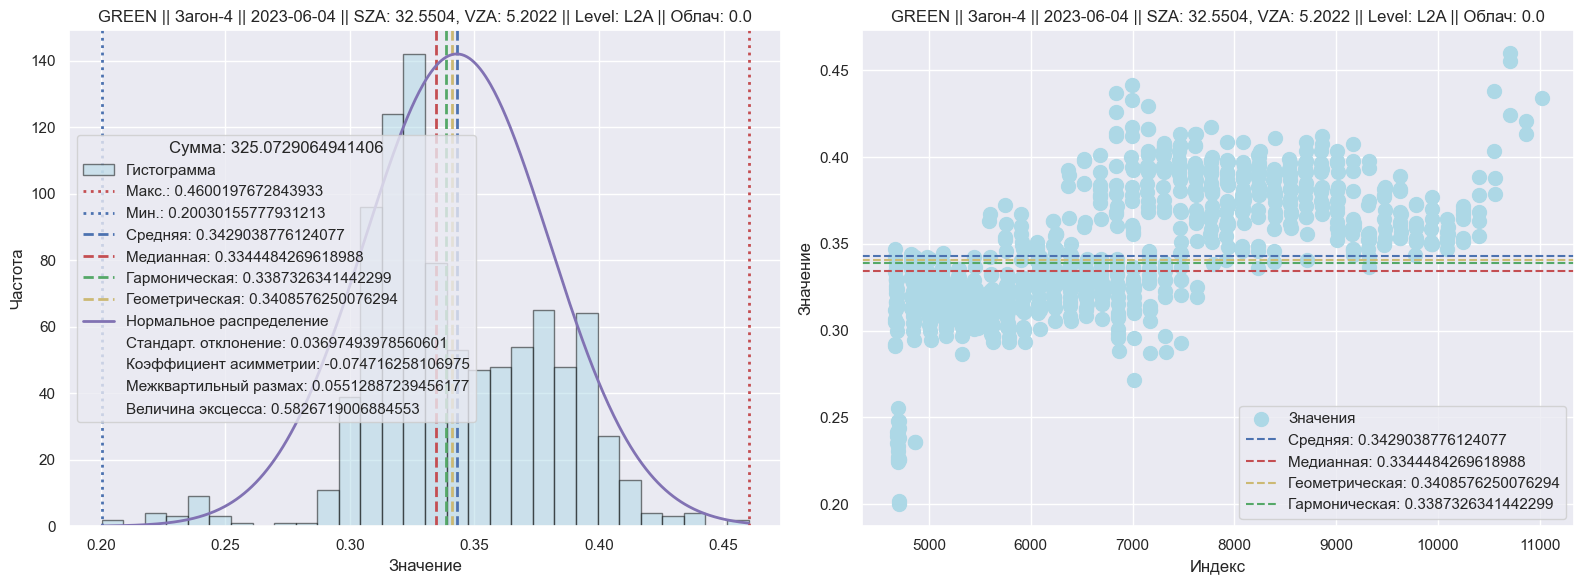

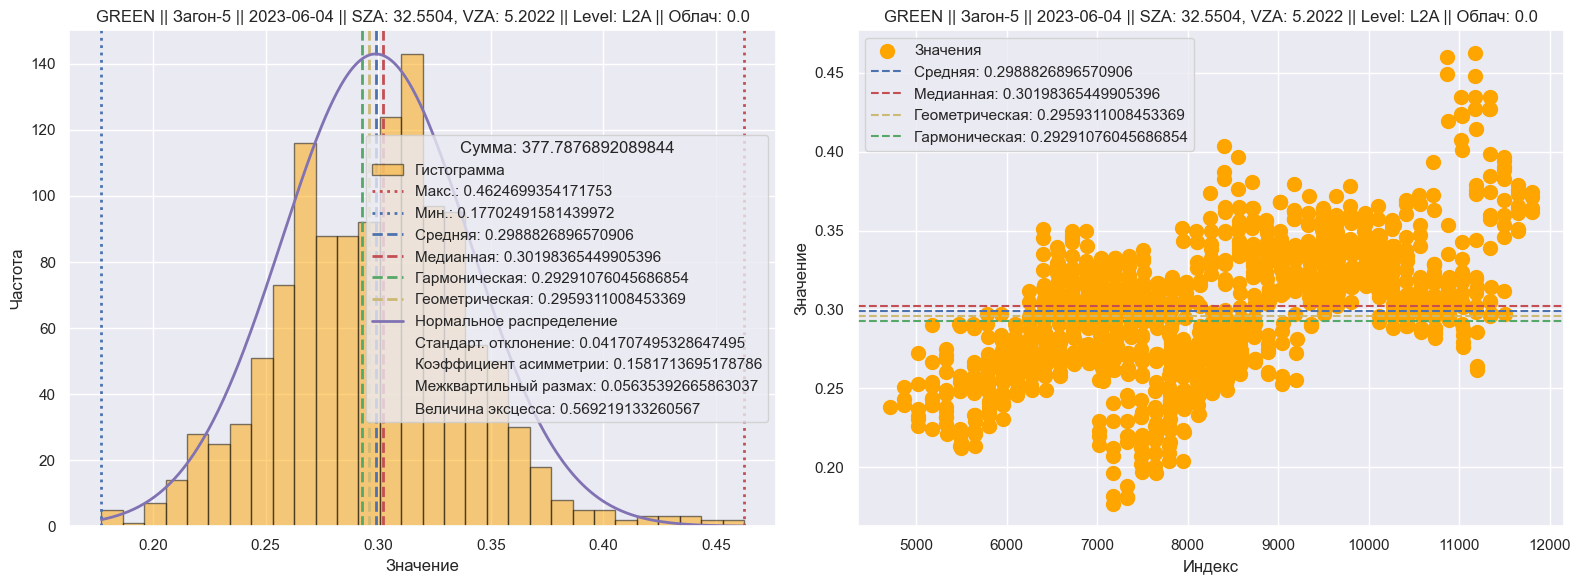

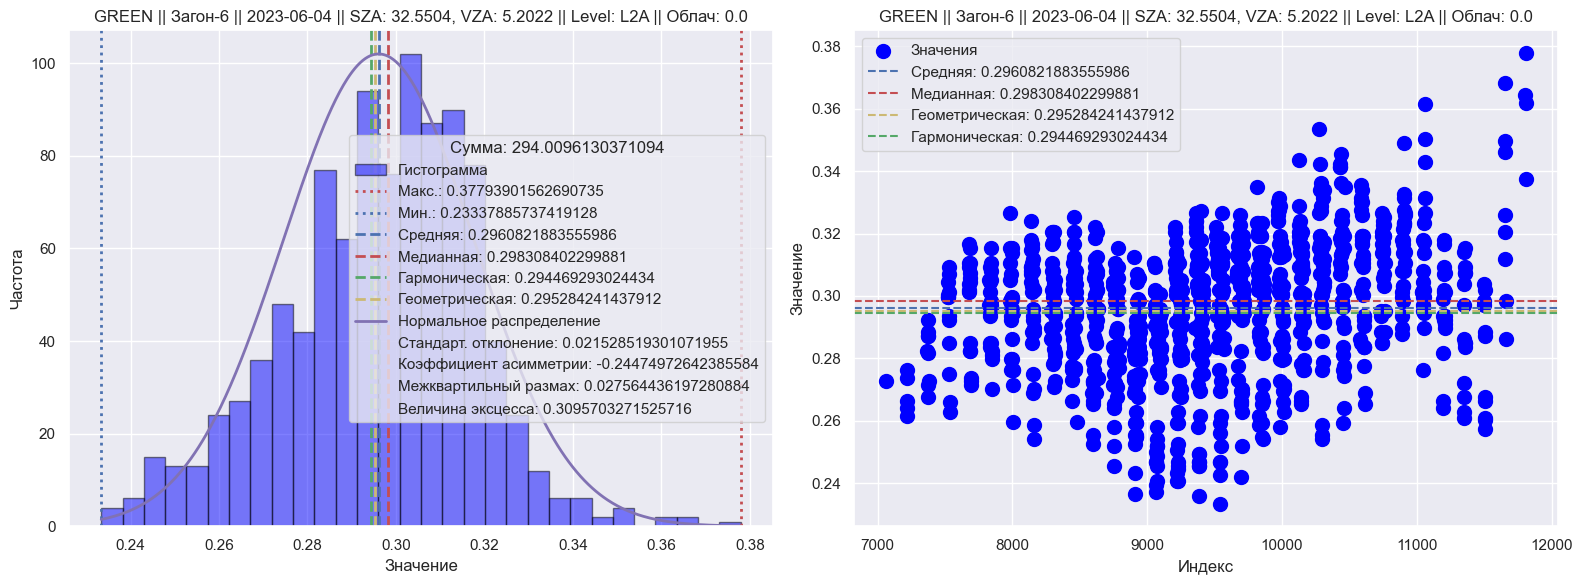

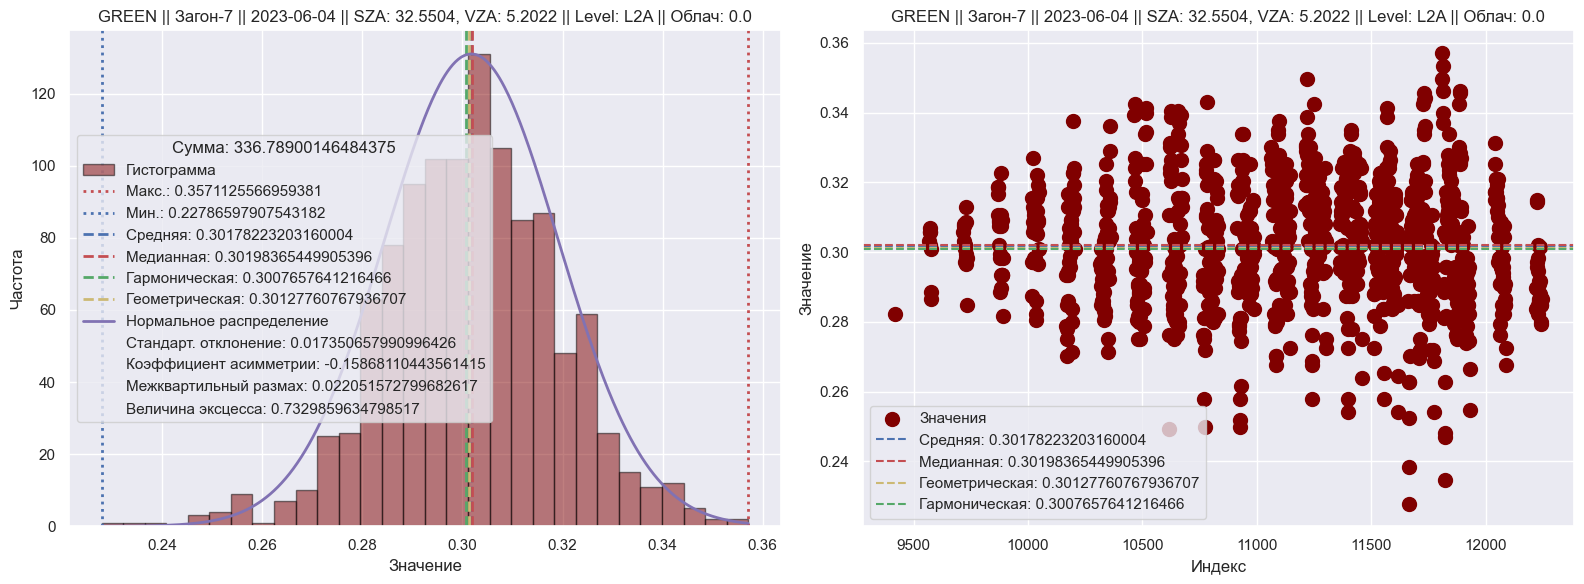

In [210]:
start_date = f'{year}-06-04'
end_date = f'{year}-06-05'

indices_dict = dict()
weather_cond_dict = {
    "pressure": [],
    "humidity": [],
    "temperature": [],
}
angles = {
    "SZA": [],
    "SAA": [],
    "VZM": [],
    "VAM": [],            
}

result_slice = get_date_slice(clear_date_dict, start_date, end_date)

for date_chosen in result_slice.keys():

    dt_object = datetime.datetime.strptime(date_chosen, "%Y-%m-%d")
    desired_time = datetime.timedelta(hours=6)
    desired_timezone = datetime.timezone.utc
    result_datetime = dt_object.replace(hour=7, minute=0, second=0, tzinfo=desired_timezone)
    alter_weather_param_df = get_main_weather_params_history(result_datetime)
    
    weather_cond_dict["temperature"].append(alter_weather_param_df["temp"].iloc[0])
    weather_cond_dict["pressure"].append(alter_weather_param_df["pressure"].iloc[0])
    weather_cond_dict["humidity"].append(alter_weather_param_df["humidity"].iloc[0])
    
    image_date = clear_date_dict[date_chosen]
    get_all_bands(by_pasture=False)
    precision = 4
    general_info = f"|| {date_chosen} || SZA: {str(round(SZA, precision))}, VZA: {str(round(VZM, precision))} || Level: {data_collection.processing_level} || Облач: {image_date_cloud[date_chosen]}"
    
    input_text = "GREEN"
#     input_text = "SWIR3"
    
    test_index = eval(input_text)
    
    test_thresh = test_index.min() 
#     test_thresh = (test_index.max() + test_index.min())/2
    
    test_filter = test_index >= test_thresh; test_mask = ~test_filter
    test_meet = ma.masked_array(test_index, mask=test_mask)
        
#     lower_bound = 0;  upper_bound = 1
    lower_bound = test_meet.min(); upper_bound = test_meet.max()
    
    
#     current_median = ma.median(test_meet)
#     coefficient = desired_median / current_median
#     test_meet = test_meet * coefficient    
    
    
#     show_real_pasture()
    show_pasture_index(test_meet, lower_bound, upper_bound, show_hists=True, save_excel=False, show_index=True, show_table=True)
    
    indices_dict[date_chosen] = test_meet

    angles["SZA"].append(SZA);
    angles["SAA"].append(SAA);
    angles["VZM"].append(VZM);
    angles["VAM"].append(VAM);    